In [2]:
import json
import pickle
import logging
import os
import warnings

import joblib
import mlflow
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, precision_recall_fscore_support, 
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

logging.basicConfig(level=logging.INFO)             #used to track the bejavior of the code in real time
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

# 9

### Model building baseline with mlflow tracking 

Functions that are useful in the general flux

In [3]:
def read_csv(file_name: str, path="data/data_processed") -> pd.DataFrame:
    """
    Read csv file
    :param file_name: file name
    :param path: path to the file
    :return: pandas dataframe
    """
    return pd.read_csv(os.path.join(path, file_name))

In [4]:
df_tickets = read_csv("tickets_inputs_eng_1.csv")

In [5]:
df_tickets.shape

(18961, 4)

In [6]:
df_tickets.sample(5)

,complaint_what_happened,ticket_classification,processed_text,relevant_topics
14002,Keep calling to take me to court without telli...,Debt collection + Credit card,court tell name theircompany.aft repeat reques...,Mortgage/Loan
1045,I began getting behind on my mortgage in XXXX ...,Mortgage + Conventional home mortgage,mortgag loss incom summer month chase individu...,Mortgage/Loan
7677,Inquire appeared on my credit report I didn't ...,"Credit reporting, credit repair services, or o...",inquir credit report account date 2018,Credit Report or Prepaid Card
14892,In XX/XX/2018 I received a shipment of somethi...,Credit card or prepaid card + General-purpose ...,receiv shipment someth order chase visa credit...,Credit Report or Prepaid Card
16304,This is in reference to case # XXXX. I have no...,Mortgage + Home equity loan or line of credit,refer case correspond chase sinc letter date a...,Mortgage/Loan


In [7]:
df_tickets.relevant_topics.value_counts() #positivo para desbalance but, la vida es así y hay que seguir adelante

relevant_topics
Bank Account Services            7069
Credit Report or Prepaid Card    6295
Mortgage/Loan                    5597
Name: count, dtype: int64

Ahora si continuamos con la parte del tracking, en este caso usamos una backend que hace parte de mlflow, pero se usa similarmente como
se hizo con sqlite.

In [8]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("tickets_baseline")


def data_transform(df: pd.DataFrame):
    """This function transform the data into X and y
    Args:
      df (pd.DataFrame): dataframe with the data
    Returns:
      X (pd.Series): series with the text
      y (pd.Series): series with the labels"""
    X = df["processed_text"]
    y = df["relevant_topics"]

    return X, y


def read_idx2label(json_path: str) -> pd.Series:
    """This function read the json file and return a dictionary
    Args:
      json_path (str): path to the json file
     Returns:
      idx2label (dict): dictionary with the mapping"""
    with open(json_path) as f:
        idx2label = json.load(f)
    return idx2label


def decode_labels_into_idx(labels: pd.Series, idx2label: dict) -> pd.Series:
    """This function decode the labels into idx
    Args:
      labels (pd.Series): series with the labels
      idx2label (dict): dictionary with the mapping
     Returns:
      labels (pd.Series): series with the labels decoded
    """
    return labels.map(idx2label)


def fit_transform(X: pd.Series) -> np.ndarray:
    count_vectorizer = CountVectorizer()
    X_vectorized = count_vectorizer.fit_transform(X)
    #save count vectorizer for data preprocessing in the main app (deploy)
    joblib.dump(count_vectorizer, 'data/data_processed/count_vectorizer.pkl')
    logger.info("count vectorizer trained successfully stored")
    return X_vectorized


def transform_tfidf(X_vectorized: object) -> np.ndarray:
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_vectorized)
    joblib.dump(X_tfidf, 'data/data_processed/X_tfidf.pkl')
    logger.info("X_tfidf trained successfully stored")
    return X_tfidf

def save_pickle(data, filename) -> None:
    """
    This function saves the data in a pickle file
    Args:
        data (object): data to save
        filename (str): filename
    Returns:
        None
    """
    filepath = os.path.join("data", "data_processed", f"{filename}.pkl")
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)

def split_train_test(
    X_tfidf: np.array, y: pd.Series, test_size: float = 0.3, random_state: int = 42
) -> tuple:
    """
    This function splits the data into train and test
    Args:
      X_tfidf (np.array): array with the vectorized data
      y (pd.Series): series with the labels
      test_size (float): test size
      random_state (int): random state
    Returns:
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=test_size, random_state=random_state
    )
    save_pickle((X_train, y_train), "train")
    save_pickle((X_test, y_test),  "test")
    logger.info("data saved successfully in pickle files")
    return X_train, X_test, y_train, y_test

def display_classification_report(
    model: object,
    name_model: str,
    developer: str,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
    use_cv = False
):
    """This function display the classification report
    Args:
        model (object): model
        name_model (str): name of the model
        developer (str): developer name
        X_train (np.array): array with the vectorized data for train
        X_test (np.array): array with the vectorized data for test
        y_train (pd.Series): series with the labels for train
        y_test (pd.Series): series with the labels for test
    Returns:
        metric (list): list with the metrics"""
    
    # star experiment in mlflow -----------------------------------------------------------------
    with mlflow.start_run(run_name=name_model):
        mlflow.log_param("model", name_model)
        mlflow.log_param("developer", developer)
        # empty list to store the metrics and then tracking them in mlflow
        metric = []
        y_train_pred_proba = model.predict_proba(X_train)
        y_test_pred_proba = model.predict_proba(X_test)
        roc_auc_score_train = round(
            roc_auc_score(
                y_train, y_train_pred_proba, average="weighted", multi_class="ovr"
            ),
            2,
        )
        roc_auc_score_test = round(
            roc_auc_score(
                y_test, y_test_pred_proba, average="weighted", multi_class="ovr"
            ),
            2,
        )

        logger.info("ROC AUC Score Train: %s", roc_auc_score_train)
        logger.info("ROC AUC Score Test: %s", roc_auc_score_test)

        
        # adding the metrics to the list to track ----------------------------------------  10
        metric.extend([roc_auc_score_train, roc_auc_score_test])

        mlflow.log_metric("roc_auc_train", roc_auc_score_train)
        mlflow.log_metric("roc_auc_test", roc_auc_score_test)

        #Make predicitons
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        (
            precision_train,
            recall_train,
            fscore_train,
            support_train,
        ) = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
        (
            precision_test,
            recall_test,
            fscore_test,
            support_test,
        ) = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

        #Store the valus of the metrics
        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("recall_test", recall_test)
        
        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()
            
            #Track gotten hyperparams stored in the dict
            mlflow.log_params(best_params)

        except AttributeError as e:
            logger.info(f"Error: {e}")

        #save the model -------------------------------------------------------------- 11
        mlflow.sklearn.log_model(model, f"model_{name_model}")

        #round to dodge redundancy xd
        acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
        acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)

        #Add the new metrics to the list
        metric.extend(
            [
                acc_score_train,
                acc_score_test,
                round(precision_train, 2),
                round(precision_test, 2),
                round(recall_train, 2),
                round(recall_test, 2),
                round(fscore_train, 2),
                round(fscore_test, 2),
            ]
        )

        print("Train Accuracy: ", acc_score_train)
        print("Test Accuracy: ", acc_score_test)

        #Variable to report the results
        model_report_train = classification_report(y_train, y_train_pred)
        model_report_test = classification_report(y_test, y_test_pred)

        print("Classification Report for Train:\n", model_report_train)
        print("Classification Report for Test:\n", model_report_test)

        # Plot the confusion matrix
        fig, ax = plt.subplots(figsize=(12, 8))

        # Create the confusion matrix with labels decoded, esto es para que los labels de lamatriz de confusión sean strings y no números
        #PAra eso se decodifica
        decoded_y_test_pred = [idx2label[idx] for idx in y_test_pred]
        decoded_y_test = [idx2label[idx] for idx in y_test]

        cm = confusion_matrix(decoded_y_test, decoded_y_test_pred)
        cmp = ConfusionMatrixDisplay(cm, display_labels=list(idx2label.values()))
        cmp.plot(ax=ax)

        plt.xticks(rotation=80)
        plt.show()

        mlflow.sklearn.log_model(model, f"models/{name_model}")

        return metric

#-------------------------------------------------------------------------------------------- 12
def grid_search(model, folds, params, scoring):
    """This function perform a grid search
    Args:
        model (object): model
        folds (int): number of folds
        params (dict): dictionary with the parameters
        scoring (str): scoring
    Returns:
        grid_search (object): grid search
    """

    #To use cross validation
    grid_search = GridSearchCV(
        model, cv=folds, param_grid=params, scoring=scoring, n_jobs=-1, verbose=1
    )
    return grid_search


#Given a model we get the best score and the corresponder hyperparams
def print_best_score_params(model):
    """This functions print best score and best hyperparameters for baselines models
    Args:
        model (object): model
    Returns:
        None"""
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

2024/08/13 17:37:04 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/08/13 17:37:04 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [9]:


idx2label = read_idx2label(json_path="data/data_processed/topic_mapping_1.json")
label2idx = {value: key for key, value in idx2label.items()}

X, y = data_transform(df_tickets)
y = decode_labels_into_idx(labels=y, idx2label=label2idx)

#Vectorize the data fo feed the model
X_vectorized = fit_transform(X.values)
X_tfidf = transform_tfidf(X_vectorized)
X_train, X_test, y_train, y_test = split_train_test(X_tfidf, y)

<h2 style="color: pink;">Modelo Multinomial Naive Bayes</h2>


Ahora no usamos cross validation, nos da el reporte del entrenamiento

2024/08/13 17:38:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Train Accuracy:  0.88
Test Accuracy:  0.86
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4937
           1       0.87      0.88      0.87      4429
           2       0.93      0.81      0.87      3906

    accuracy                           0.88     13272
   macro avg       0.88      0.87      0.88     13272
weighted avg       0.88      0.88      0.88     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      2132
           1       0.84      0.85      0.84      1866
           2       0.92      0.79      0.85      1691

    accuracy                           0.86      5689
   macro avg       0.86      0.85      0.86      5689
weighted avg       0.86      0.86      0.86      5689



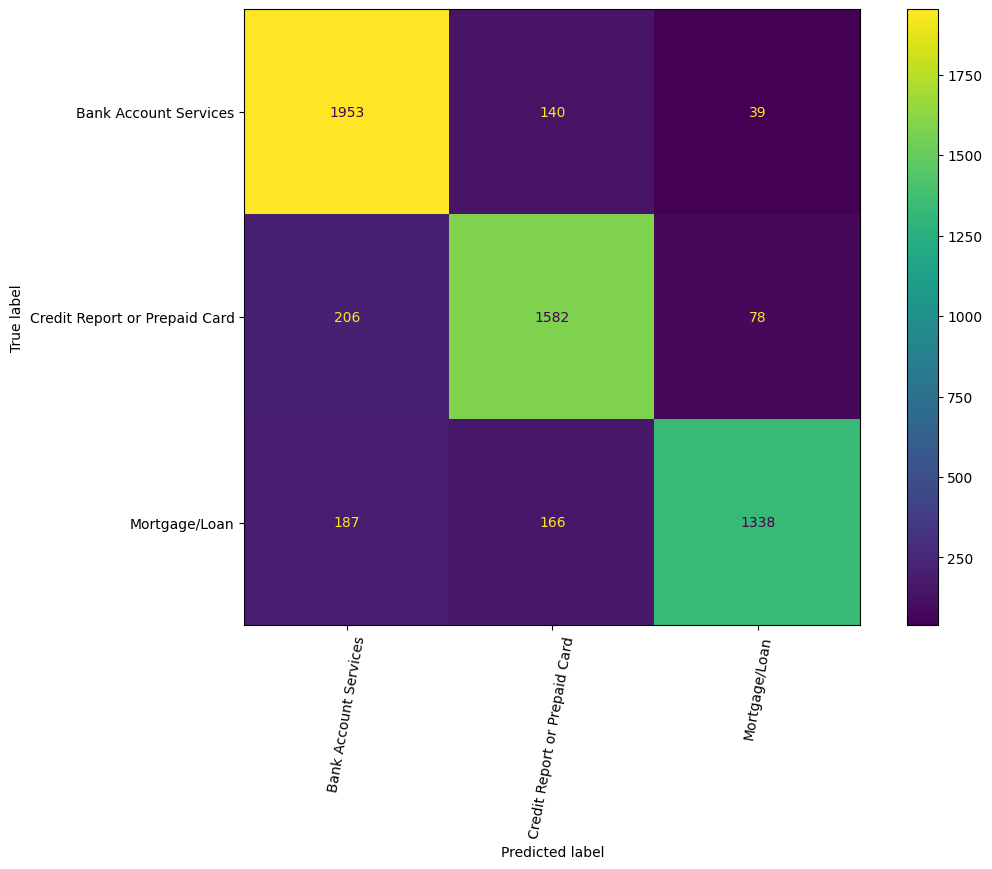

2024/08/13 17:38:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


[0.97, 0.96, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86]

In [10]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
display_classification_report(model=mnb, 
                              name_model="MultinomialNB", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

<h2 style="color: pink;">Modelo Multinomial Naive Bayes con GreadSearch</h2>

El mismo modelo pero aplicando un grid search para mejorar los resultados

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score:  0.8473478684769604
Best Hyperparameters:  {'alpha': 1}


2024/08/13 17:42:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Train Accuracy:  0.88
Test Accuracy:  0.86
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4937
           1       0.87      0.88      0.87      4429
           2       0.93      0.81      0.87      3906

    accuracy                           0.88     13272
   macro avg       0.88      0.87      0.88     13272
weighted avg       0.88      0.88      0.88     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      2132
           1       0.84      0.85      0.84      1866
           2       0.92      0.79      0.85      1691

    accuracy                           0.86      5689
   macro avg       0.86      0.85      0.86      5689
weighted avg       0.86      0.86      0.86      5689



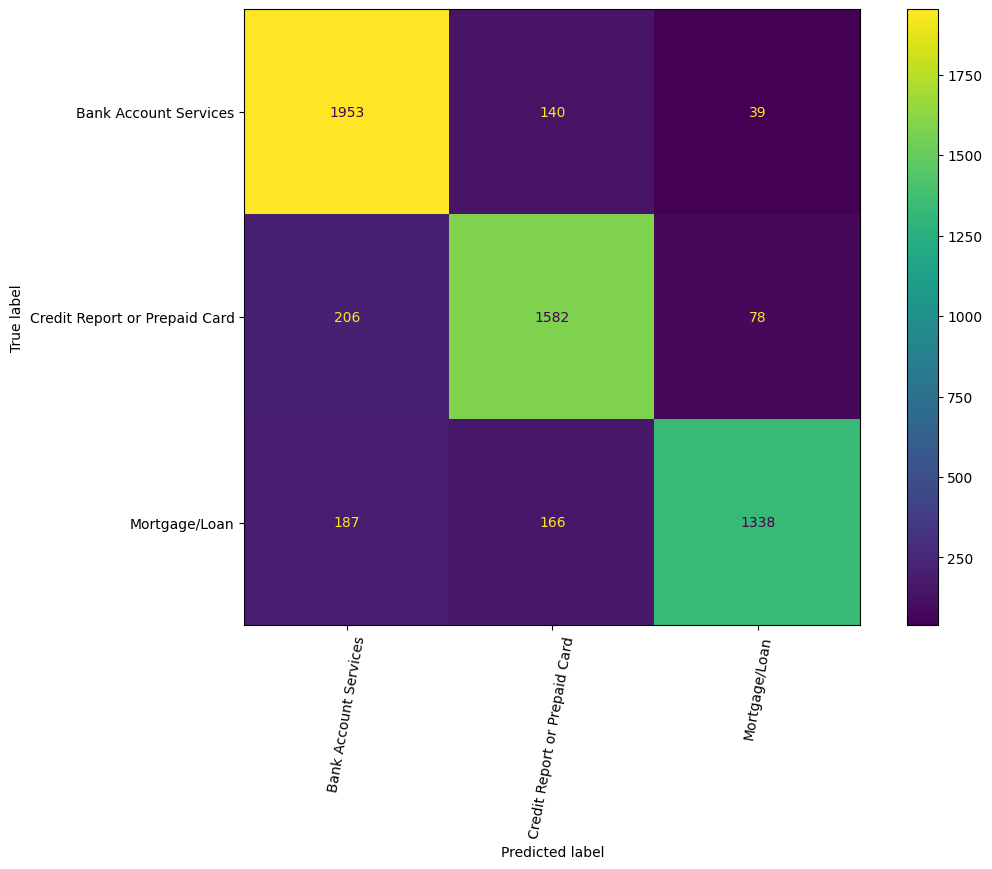

2024/08/13 17:42:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


[0.97, 0.96, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86]

In [11]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)
mnb = MultinomialNB()
mnb_params = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)  
}
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring="f1_micro")
grid_search_mnb.fit(X_train, y_train)
print_best_score_params(grid_search_mnb)

display_classification_report(model=grid_search_mnb, 
                              name_model="MultinomialNBCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv= True)

<h2 style="color: pink;">Logistic Regression</h2>

INFO:__main__:ROC AUC Score Train: 1.0
INFO:__main__:ROC AUC Score Test: 1.0


Train Accuracy:  0.99
Test Accuracy:  0.97
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4995
           1       0.99      0.99      0.99      4663
           2       1.00      0.98      0.99      3611

    accuracy                           0.99     13269
   macro avg       0.99      0.99      0.99     13269
weighted avg       0.99      0.99      0.99     13269

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      2038
           1       0.97      0.98      0.97      2132
           2       0.98      0.94      0.96      1518

    accuracy                           0.97      5688
   macro avg       0.97      0.96      0.97      5688
weighted avg       0.97      0.97      0.97      5688



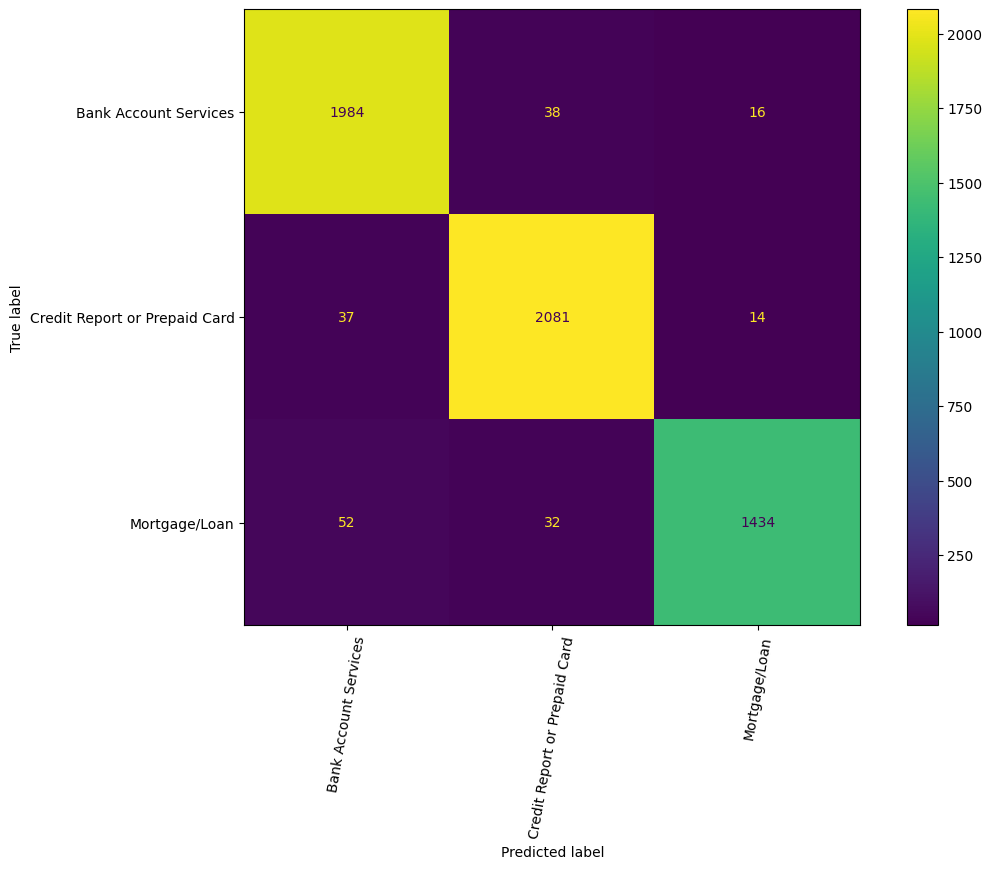

[1.0, 1.0, 0.99, 0.97, 0.99, 0.97, 0.99, 0.97, 0.99, 0.97]

In [18]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
log_reg.fit(X_train,y_train)
display_classification_report(model=log_reg, 
                              name_model="LogisticRegression", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=False)

<h2 style="color: pink;">Logistic Regression with GreadSearch</h2>

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/mdurango/Proyect/Mlops-platzi/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mdurango/Proyect/Mlops-platzi/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mdurango/Proyect/Mlops-platzi/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mdurango/Proyect/Mlops-platzi/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mdurango/Proyect/Mlops-platzi/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Best Score:  0.983983983983984
Best Hyperparameters:  {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


--- Logging error ---
Traceback (most recent call last):
  File "/Users/mdurango/.pyenv/versions/3.9.17/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/Users/mdurango/.pyenv/versions/3.9.17/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/Users/mdurango/.pyenv/versions/3.9.17/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/Users/mdurango/.pyenv/versions/3.9.17/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/mdurango/.pyenv/versions/3.9.17/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/mdurango/.pyenv/versions/3.9.17/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/mdurango/Proyect/Mlops-platzi/.venv/

Train Accuracy:  1.0
Test Accuracy:  0.98
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4995
           1       1.00      1.00      1.00      4995
           2       1.00      1.00      1.00      4995

    accuracy                           1.00     14985
   macro avg       1.00      1.00      1.00     14985
weighted avg       1.00      1.00      1.00     14985

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2038
           1       0.99      0.98      0.98      2132
           2       0.98      0.98      0.98      1518

    accuracy                           0.98      5688
   macro avg       0.98      0.98      0.98      5688
weighted avg       0.98      0.98      0.98      5688



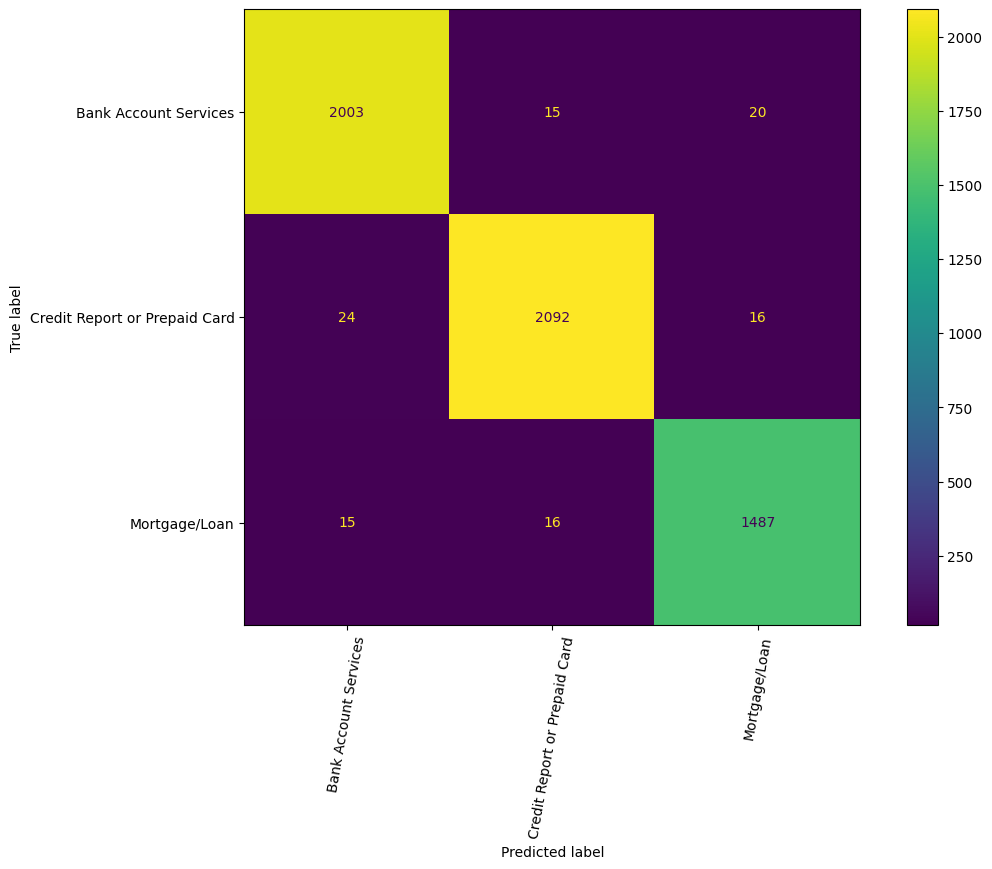

[1.0, 1.0, 1.0, 0.98, 1.0, 0.98, 1.0, 0.98, 1.0, 0.98]

In [12]:
# rebalance of the data
smote = SMOTE()
# transform the dataset with the SMOTE algorithm
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# define the model with the balanced class_weight
log_reg = LogisticRegression(class_weight='balanced')

log_params = {'C': [0.01, 1, 10], 
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

grid_search_log = grid_search(log_reg, folds, log_params, scoring="f1_micro")
grid_search_log.fit(X_train_res, y_train_res)  # entrenamiento con los datos rebalanceados

print_best_score_params(grid_search_log)
display_classification_report(grid_search_log,
                              name_model="LogisticRegressionCVSmote", 
                              developer="Maria", 
                              X_train=X_train_res,  # evaluación con los datos rebalanceados
                              X_test=X_test, 
                              y_train=y_train_res,  # etiquetas rebalanceadas
                              y_test=y_test, 
                              use_cv=True)

<h2 style="color: pink;">Decision Tree Classifier</h2>

2024/08/13 17:45:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Train Accuracy:  1.0
Test Accuracy:  0.86
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4937
           1       1.00      1.00      1.00      4429
           2       1.00      1.00      1.00      3906

    accuracy                           1.00     13272
   macro avg       1.00      1.00      1.00     13272
weighted avg       1.00      1.00      1.00     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      2132
           1       0.86      0.86      0.86      1866
           2       0.85      0.85      0.85      1691

    accuracy                           0.86      5689
   macro avg       0.86      0.86      0.86      5689
weighted avg       0.86      0.86      0.86      5689



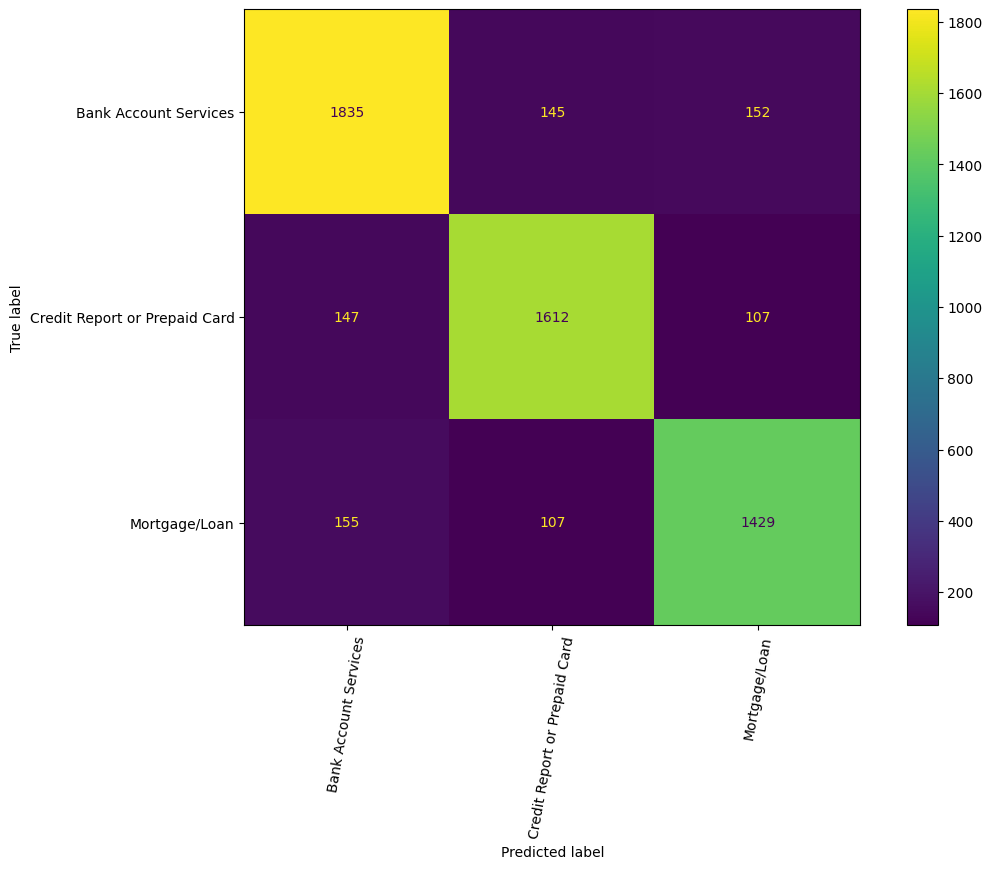

2024/08/13 17:45:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


[1.0, 0.89, 1.0, 0.86, 1.0, 0.86, 1.0, 0.86, 1.0, 0.86]

In [12]:
dtc = DecisionTreeClassifier(random_state=40)
dtc.fit(X_train,y_train)
display_classification_report(model=dtc,
                              name_model="DecisionTreeClassifier",
                              developer="Maria",
                              X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test,
                              use_cv=False)

<h2 style="color: pink;">Decision Tree Classifier with Gread Search</h2>

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best Score:  0.870619206133405
Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 7, 'splitter': 'best'}


2024/08/13 17:46:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Train Accuracy:  0.94
Test Accuracy:  0.87
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      4937
           1       0.94      0.96      0.95      4429
           2       0.95      0.93      0.94      3906

    accuracy                           0.94     13272
   macro avg       0.94      0.94      0.94     13272
weighted avg       0.94      0.94      0.94     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2132
           1       0.86      0.89      0.88      1866
           2       0.88      0.85      0.86      1691

    accuracy                           0.87      5689
   macro avg       0.87      0.87      0.87      5689
weighted avg       0.87      0.87      0.87      5689



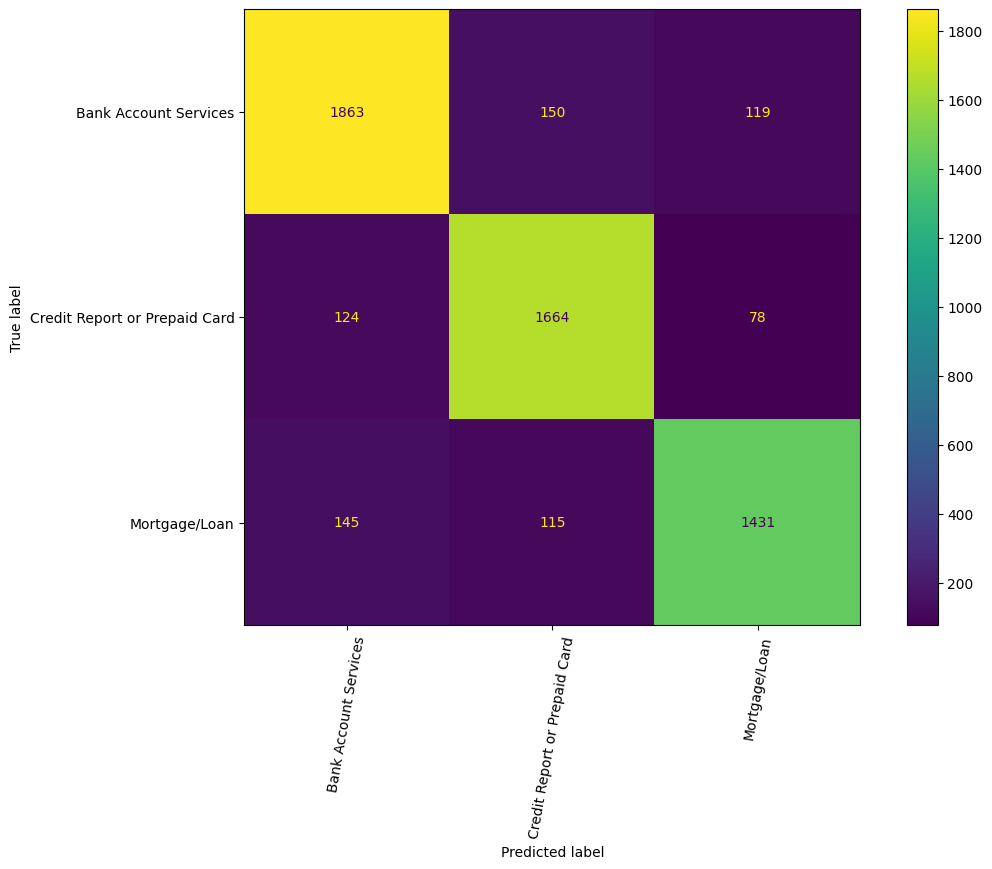

2024/08/13 17:46:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


[1.0, 0.94, 0.94, 0.87, 0.94, 0.87, 0.94, 0.87, 0.94, 0.87]

In [13]:
# decis|on tree classifier with grid search
dtc_cv = DecisionTreeClassifier(random_state=40)

dtc_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2,3,4,5,6,7,8,None],
    'min_samples_leaf': [2,3,4,7],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
grid_search_dtc = grid_search(dtc_cv, folds, dtc_params, scoring='f1_macro')
grid_search_dtc.fit(X_train, y_train)
print_best_score_params(grid_search_dtc)
display_classification_report(grid_search_dtc, 
                              name_model="DecisionTreeClassifierCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=True)

* No olvides ejecutar mlflow ui --backend-store-uri sqlite:///mlflow.db para visualizar los resultados

# 11

<h2 style="color: pink;">Hacer inferencias con el modelo</h2>

In [14]:
logged_model = 'runs:/0592cd619ab24fa88935373f5e606fe5/models/DecisionTreeClassifierCV'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [16]:
#Good practice, check the shape
assert X_train.toarray().shape[0] == y_train.shape[0]

In [15]:
#To see some infor
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models/DecisionTreeClassifierCV
  flavor: mlflow.sklearn
  run_id: 0592cd619ab24fa88935373f5e606fe5

In [27]:
#Cargamos el modelo con scikti learn como una instancia u objeto, tiene los métodos como get_params, predict, etc
lr_model = mlflow.sklearn.load_model(logged_model)

In [28]:
lr_model.get_params()

{'cv': StratifiedKFold(n_splits=5, random_state=40, shuffle=True),
 'error_score': nan,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__random_state': 40,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(random_state=40),
 'n_jobs': -1,
 'param_grid': {'criterion': ['gini', 'entropy'],
  'splitter': ['best', 'random'],
  'max_depth': [2, 3, 4, 5, 6, 7, 8, None],
  'min_samples_leaf': [2, 3, 4, 7],
  'max_features': ['auto', 'sqrt', 'log2', None]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'f1_macro',
 'verbose': 1}

In [20]:
#Podemos hacer predicciones!
lr_model.predict(X_test)

array(['2', '0', '0', ..., '1', '0', '0'], dtype=object)

Ahora nos conectamos con el cliente de mlflow, basados en un backend dado

In [21]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

Básicamente entramos a esa bse de datos y revisamos los eperimentos que tenemos guardados

In [22]:
runs = mlflow.search_runs()
# Extrae los IDs únicos de los experimentos
experiment_ids = runs['experiment_id'].unique()

In [25]:
experiment_ids

array(['1'], dtype=object)

In [24]:
#Creamos un nuevo experimento en el backend, si corremos esto, ahora tendra emos un experimento más en la lista que se muestra en el servidor
#la celda anterior si se corre sigue mostrando unsolo experimento porque aún no hemos agrado un run name, una vez hecho esto, 
#Ya sí se mostrá la lista con el nuevo exp.
client.create_experiment("regression_models")

'2'

In [26]:
#Extraer todos los run del experimento con ID 1

runs = client.search_runs(experiment_ids=["1"])
for run in runs:
    print(run.info)

<RunInfo: artifact_uri='/home/sebastian/Desktop/For_studyng/MLOPS_MLdeploy/Mlops-platzi/tracking/mlruns/1/0592cd619ab24fa88935373f5e606fe5/artifacts', end_time=1723589197885, experiment_id='1', lifecycle_stage='active', run_id='0592cd619ab24fa88935373f5e606fe5', run_name='DecisionTreeClassifierCV', run_uuid='0592cd619ab24fa88935373f5e606fe5', start_time=1723589194907, status='FINISHED', user_id='sebastian'>
<RunInfo: artifact_uri='/home/sebastian/Desktop/For_studyng/MLOPS_MLdeploy/Mlops-platzi/tracking/mlruns/1/e14d747a78e546ff8c9c4cf337545ec2/artifacts', end_time=1723589123366, experiment_id='1', lifecycle_stage='active', run_id='e14d747a78e546ff8c9c4cf337545ec2', run_name='DecisionTreeClassifier', run_uuid='e14d747a78e546ff8c9c4cf337545ec2', start_time=1723589120404, status='FINISHED', user_id='sebastian'>
<RunInfo: artifact_uri='/home/sebastian/Desktop/For_studyng/MLOPS_MLdeploy/Mlops-platzi/tracking/mlruns/1/691215a4143a4be8b8de1671c415f0cd/artifacts', end_time=1723588957817, exper

💚 Ahora vayamos a la UI y miremos los resultados de los modelos y hagamos un registro de un par de modelos con mejor performancce. 

<p align="center">
  <img src="https://pbs.twimg.com/media/EoOBoWyWEAAA8In.jpg" width="400" style="display: block; margin: auto;">
</p>

### Promote a model

# 14

In [48]:
#Usamos el mismp cliente de mlflow de la clase pasada
#Buscamos los runs con ID 1, podemos filtrar por tags!
runs= client.search_runs(
    experiment_ids='1',
    filter_string="", #se puede usar un tag en especial o algún parámetro de interés ej: 'tags.model = valor que usaste
    run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY,         #solo queremos los modelos activos
    max_results=5,
    order_by=["metrics.precision_test DESC"]        #La columna esxtra que agregamos para saver qué modelos eran mehor de escoger

)

In [49]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse_valid: {run.data.metrics['precision_test']}")

run id: 0592cd619ab24fa88935373f5e606fe5, rmse_valid: 0.8716876918644566
run id: 691215a4143a4be8b8de1671c415f0cd, rmse_valid: 0.8601577541286356
run id: d8f7d82a23504a598688f934c2e06f14, rmse_valid: 0.8601577541286356
run id: e14d747a78e546ff8c9c4cf337545ec2, rmse_valid: 0.8570883993165163


In [50]:
#Aquí podemos usar uno de los ID anteriores, extraemos el modelo
#Con el nombnre tickets_classifiers tenías por error solo un modelo creado, entonces se crea el segundo modelo
#Porque encontró que ya teníamos uno

run_id = "0592cd619ab24fa88935373f5e606fe5"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri, "tickets_classifiers")

Registered model 'tickets_classifiers' already exists. Creating a new version of this model...
Created version '4' of model 'tickets_classifiers'.


<ModelVersion: aliases=[], creation_timestamp=1723596502020, current_stage='None', description=None, last_updated_timestamp=1723596502020, name='tickets_classifiers', run_id='0592cd619ab24fa88935373f5e606fe5', run_link=None, source='/home/sebastian/Desktop/For_studyng/MLOPS_MLdeploy/Mlops-platzi/tracking/mlruns/1/0592cd619ab24fa88935373f5e606fe5/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=4>

In [51]:
#Revisa cuál es el status de los modelos registrados bajo el nombre de tickets_classifier
#De ahora en adelante, ese es el nombre de nuestro modelo

model_name = "tickets_classifiers"
latest_versions = client.get_latest_versions(name=model_name)
for version in latest_versions:
    print(f" version: {version.version} , actual stage: {version._current_stage}")

 version: 1 , actual stage: Production
 version: 2 , actual stage: Staging
 version: 4 , actual stage: None


In [45]:
#Podemos cambiar el stage the alguna verisón en particular, en este caso le ponemos staging a la versión 2

client.transition_model_version_stage(
    name=model_name,
    version=2,
    stage="Staging"
)

<ModelVersion: aliases=[], creation_timestamp=1723594325316, current_stage='Staging', description='The model version 2 was transitioned to Production on 2024-08-13', last_updated_timestamp=1723595925951, name='tickets_classifiers', run_id='0592cd619ab24fa88935373f5e606fe5', run_link=None, source='/home/sebastian/Desktop/For_studyng/MLOPS_MLdeploy/Mlops-platzi/tracking/mlruns/1/0592cd619ab24fa88935373f5e606fe5/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [52]:
#Podemos hacer lo mismo para pasr a producción.

client.transition_model_version_stage(
    name=model_name,
    version=1,
    stage="Production"
)

<ModelVersion: aliases=[], creation_timestamp=1723594251640, current_stage='Production', description=None, last_updated_timestamp=1723596551823, name='tickets_classifiers', run_id='0592cd619ab24fa88935373f5e606fe5', run_link=None, source='/home/sebastian/Desktop/For_studyng/MLOPS_MLdeploy/Mlops-platzi/tracking/mlruns/1/0592cd619ab24fa88935373f5e606fe5/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [53]:
#Podemos cambiar incluso la descricciónS

client.update_model_version(
    name=model_name, 
    version=1,
    description=f"The model version {3} was transitioned to Production on {datetime.today().date()}"
)

<ModelVersion: aliases=[], creation_timestamp=1723594251640, current_stage='Production', description='The model version 3 was transitioned to Production on 2024-08-13', last_updated_timestamp=1723596553057, name='tickets_classifiers', run_id='0592cd619ab24fa88935373f5e606fe5', run_link=None, source='/home/sebastian/Desktop/For_studyng/MLOPS_MLdeploy/Mlops-platzi/tracking/mlruns/1/0592cd619ab24fa88935373f5e606fe5/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [54]:
type(y_test)

pandas.core.series.Series

# 15

## Sometamos a prueba el modelo que hemos registrado para producción

In [55]:
import scipy

In [56]:
def testint_model_from_mlflow(model_name: str, stage:str, X_test: scipy.sparse._csr.csr_matrix, Y_test: pd.Series):
    """this function tests a model from mlflow
    Args:
        model_name (str): name of the model
        stage (str): stage of the model
        X_test (scipy.sparse._csr.csr_matrix): test data
        Y_test (scipy.sparse._csr.csr_matrix): test target
    Returns:
        float: rmse of the model
    
    """
    model_uri = f"models:/{model_name}/{stage}"
    model = mlflow.pyfunc.load_model(model_uri)                     #This is how we load the model
    y_pred = model.predict(X_test)
    acc_score = round(accuracy_score(Y_test, y_pred), 2)
    return {"rmse": acc_score}

In [ ]:
#This should have worked, but it did not, meybe because they changed the mlflow version and the
#stage concept ins not available anymore
%time
testint_model_from_mlflow(model_name= "tickets_classifiers ", stage="Production", X_test=X_test, Y_test=y_test)

## Ventajas de MLflow:

* Gestión de Ciclo de Vida: Facilita el seguimiento de experimentos, versionado de modelos y reproducción de resultados.
* Interoperabilidad: Es compatible con múltiples frameworks de aprendizaje automático y se integra fácilmente en flujos de trabajo existentes.
* Abierto y Modular: Ofrece una arquitectura modular que permite la flexibilidad y personalización.
* Trazabilidad y Reproducibilidad: Registra métricas, parámetros y artefactos para reproducir modelos y resultados.
* Comunidad Activa: Amplia comunidad de usuarios y contribuciones continuas.

## Desventajas de MLflow:
* Complejidad para Grandes Volúmenes de Datos: Puede enfrentar dificultades al manejar grandes volúmenes de datos o flujos de trabajo muy complejos.
* Curva de Aprendizaje: Requiere tiempo para familiarizarse con todas sus funcionalidades y componentes.
* Limitaciones en Algunas Funcionalidades: Algunas funcionalidades pueden no ser tan avanzadas o flexibles como en otras herramientas especializadas.

## Alternativas a MLflow:
* TensorBoard: Enfoque específico para TensorFlow, útil para visualizar gráficamente métricas, grafos de modelos y más.
* DVC (Data Version Control): Se enfoca en versionado de datos y modelos, y gestión de experimentos.
* Comet.ml: Ofrece seguimiento de experimentos, colaboración y visualización de manera similar a MLflow.
* Weights & Biases: Ofrece seguimiento de experimentos, colaboración y visualización de manera similar a MLflow.


## 💚 Conclusiones
* Podemos trackear metadata

* Registrar modelos

* Obtener los requirimientos del ambiente de desarrollo donde fue entrenado los modelos

* Podemos hacer un seguimiento de los modelos y compararlos de forma fácil y amigable con la interfaz de MLflow y en código

